In [1]:
!pip install transformers

In [2]:
# --> for cleaning:
!pip install langdetect

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizerFast, AutoModel,AdamW
from google.cloud import bigquery
from langdetect import detect
from google.colab import auth,drive
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# specify GPU
device = torch.device("cuda")

In [4]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
auth.authenticate_user()

In [6]:
project_id = 'tlac-vision'

client = bigquery.Client(project=project_id)
df = client.query('''
  SELECT
    *
  FROM
    `tlac-vision.book_backend.train_categories`
''').to_dataframe()

In [7]:
# --> sorting dataframe by book category, from A to Z
df = df.sort_values(['category'], ascending=True)

# --> dropping duplicate rows
df = df.drop_duplicates(['title']).reset_index(drop=True)

In [8]:
# --> deleting results that are in other languages different to spanish
df['language'] = ""
for index, row in df.iterrows():
    row['language'] = detect(row['description'])
df = df[df.language == 'es']

cat_count = df.iloc[:,0:2].groupby('category').count().rename(columns={'title': 'count'})  # total of registers per category

In [9]:
# --> 75% of data is for training
cat_count['training'] = round(0.75 * cat_count['count'], 0)

# --> organizing indexes to split data
cat_count['acum'] = cat_count['count'].cumsum()
cat_count['init_idx'] = cat_count['acum'] - cat_count['count']
cat_count['train_idx'] = cat_count['init_idx'] + cat_count['training']

In [10]:
# --> creating training set with 75% of data per category
train_set = pd.DataFrame(data=None, columns=df.columns)
for i in range(len(cat_count)):
    i_idx = int(cat_count.iloc[i, 3])
    f_idx = int(cat_count.iloc[i, 4])
    train_set = train_set.append(df.iloc[i_idx:f_idx, :])

train_set_f = train_set.loc[:, ['category', 'description']]
train_set_f=train_set_f.reset_index(drop=True)
#train_set_f['is_valid']=False
train_set_f.iloc[0:5,]

,category,description
0,anthropology,"""Después de 60 años como misionero en el Perú ..."
1,anthropology,A lo largo de los últimos cien años la antropo...
2,anthropology,"En este libro, uno de los principales teoricos..."
3,anthropology,"El fuego, presente ya en los inicios del proce..."
4,anthropology,Este ambicioso tratado sobre el fenómeno relig...


In [11]:
# --> creating validation set with 25% of data per category
val_set = pd.DataFrame(data=None, columns=df.columns)
for i in range(len(cat_count)):
    i_idx = int(cat_count.iloc[i, 4])
    f_idx = int(cat_count.iloc[i, 2])
    val_set = val_set.append(df.iloc[i_idx:f_idx, :])

val_set_f = val_set.loc[:, ['category', 'description']]
val_set_f=val_set_f.reset_index(drop=True)
#val_set_f['is_valid']=True
val_set_f.iloc[0:5,]

,category,description
0,anthropology,Antología preparada en torno al axolote (o axó...
1,anthropology,Sirviéndose de los recursos metodológicos prop...
2,anthropology,Este trabajo consta de dos partes bien diferen...
3,anthropology,"Los problemas de la bioética no solo son, en l..."
4,anthropology,"La ANTROPOLOGÍA kantiana, más que en la divers..."


In [12]:
id_label = dict(zip(train_set_f['category'].unique(), range(0,11))) #categorical labels to numerical
train_labels,train_text= train_set_f['category'].map(id_label),train_set_f['description']
val_labels,val_text= val_set_f['category'].map(id_label),val_set_f['description']

In [13]:
tokenizer = BertTokenizerFast.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")
bert_es = AutoModel.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased") #pretrained model

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f574a8994a8>]],
      dtype=object)

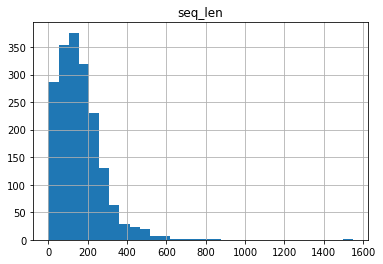

In [14]:
# --> distribution of the sequence lengths(number of words) in the train set to find the padding length 
seq_len = pd.DataFrame([len(i.split()) for i in train_set_f['description']],columns=['seq_len'])
seq_len.hist(bins = 30)

In [15]:
def intervals():
  to_return=list()
  j=0
  for i in range(0,32):
    to_return.append(j)
    j+=50

  return to_return
    
ranges = intervals()

sl_grouped=seq_len.groupby(pd.cut(seq_len.seq_len, ranges)).count().rename(columns={'seq_len':''})
sl_grouped=sl_grouped.add_suffix('count').reset_index()
sl_grouped['%']=round(100*sl_grouped['count'].cumsum()/sl_grouped['count'].sum(),3)

sl_grouped.iloc[0:10,:] 

,seq_len,count,%
0,"(0, 50]",268,14.455
1,"(50, 100]",349,33.279
2,"(100, 150]",359,52.643
3,"(150, 200]",314,69.579
4,"(200, 250]",243,82.686
5,"(250, 300]",147,90.615
6,"(300, 350]",67,94.229
7,"(350, 400]",36,96.170
8,"(400, 450]",24,97.465
9,"(450, 500]",23,98.706


In [16]:
# --> tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 250,
    padding='max_length',
    truncation=True
)

# --> tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 250,
    padding='max_length',
    truncation=True
)

In [17]:
# --> sample data for BETO
text = ["esta es una prueba","estoy haciendo una prueba"]
sent_id = tokenizer.batch_encode_plus(text, padding=True) # encode text
print(sent_id)

{'input_ids': [[4, 1149, 1028, 1091, 3610, 5], [4, 1435, 2194, 1091, 3610, 5]], 'token_type_ids': [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]}


In [18]:
# --> convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

In [19]:
#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data
train_sampler = RandomSampler(train_data)
val_sampler = SequentialSampler(val_data)

# dataLoaders
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [20]:
#  --> freeze all the layers of the model before fine-tuning it

for param in bert_es.parameters():
    param.requires_grad = False

In [32]:
# --> model architecture

class BERT_Arch(nn.Module):

    def __init__(self, bert_es):
      
      super(BERT_Arch, self).__init__()
      self.bert_es = bert_es 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,11)  ####last layer equal to number of classes
      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
      #pass the inputs to the model  
      _, cls_hs = self.bert_es(sent_id, attention_mask=mask)
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [33]:
# --> pass the pre-trained BERT in spanish to architecture
model = BERT_Arch(bert_es)

# push the model to GPU
model = model.to(device)

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-5) 

#compute class weights for the labels in the train set and then pass these weights to the loss function so that it takes care of the class imbalance

class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print("Class Weights:",class_weights)

Class Weights: [2.21770335 0.84272727 1.81231672 0.81818182 0.81422925 0.98564593
 0.86433566 0.87329251 0.88243693 0.95764463 1.15442092]


In [34]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

**Finetuning**

In [35]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [36]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:

# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')